In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import floor
from rich import print

Utilizaremos los siguientes generadores de números uniformes:
- `Lineal congruential generator (LCG)`
- `XORShift (64 bits)`
- `Mersenne Twister (MT19937)`

In [2]:
class LCG:
    def __init__(self, seed):
        self.state = seed
        self.a = 16807
        self.m = 2**31 - 1
        self.c = 0
    
    def random(self):
        self.state = (self.state * self.a + self.c) % self.m
        return self.state / self.m # Normalize to [0, 1)

In [3]:
class Xorshift64:
    def __init__(self, seed):
        if seed == 0:
            raise ValueError("Seed must be non-zero")
        self.state = seed % (2**64)   
         
    def random(self):
        x = self.state
        # Apply the mask after each operation to keep it within 64-bit range
        x = (x ^ (x << 13)) & 0xFFFFFFFFFFFFFFFF
        x = (x ^ (x >> 7)) & 0xFFFFFFFFFFFFFFFF
        x = (x ^ (x << 17)) & 0xFFFFFFFFFFFFFFFF
        self.state = x
        
        return self.state / (2**64) # Normalize to [0, 1)

In [4]:
def MT19937(seed):
    """
    Mersenne Twister (MT19937) to generate a pseudo-random variable.  
    Returns a Generator object.
    """
    return np.random.Generator(bit_generator=np.random.MT19937(seed))

In [5]:
class RNG:
    """
    Random Number Generator (RNG)
    Use this class to generate a random number using some of the available generators:
    - xorshift64
    - mt19937
    - lcg
    The default algorithm is xorshift64.
    You can also pass a seed to the RNG. If no seed is provided, the current time in nanoseconds is used as the seed.
    The seed must be non-zero for xorshift64 and lcg algorithms.
    
    Usage:
    Without passing seed:
    r = RNG("xorshift64")
    r.random()
    
    Passing seed:
    r = RNG("xorshift64", seed=1234)
    r.random()
    """
    def __init__(self, algo='xorshift64', seed=None):
        if seed is None:
            seed = 1234
        
        self.algo = algo.lower()
        
        if self.algo == 'xorshift64':
            if seed == 0:
                raise ValueError("Seed must be non-zero for Xorshift64")
            self.generator = Xorshift64(seed)
        elif self.algo == 'mt19937':
            self.generator = MT19937(seed)
        elif self.algo == 'lcg':
            self.generator = LCG(seed)
        else:
            raise ValueError(f"Unknown algorithm: {self.algo}")
    
    def random(self):
        return self.generator.random()

#### Intensidad del proceso Poisson homogéneo
$$
    \lambda(t) = 30 + 30 \cdot \sin\left(\frac{2\pi t}{24}\right) \text{ (clientes/hora)}
$$

In [6]:
# Intensidad del Poisson proceso homogéneo
def lambda_t(t):
    """
    Intensity function for a homogeneous Poisson process.
    """
    return 30 + 30 * np.sin((2*np.pi*t)/24)


#### Tiempo de Atención

Corresponde a una distribución exponencial con tasa $ \mu = 40 $ (clientes / hora).  
Para calcular el tiempo de atención usamos la transformada inversa:
$$
    T = -\frac{1}{40} \ln{U}
$$

In [7]:
def service_time(gen: RNG):
    u = gen.random()
    return -np.log(u) / 40

#### Servidor

El servidor se encarga de procesar la lista de eventos t_arrivals.  
La función devuelve metricas sobre el uso y evolución del sistema a lo largo del tiempo:

- **Tiempo promedio en el sistema por cliente:**  
    $ \text{t\_end\_service}[i] - \text{t\_arrivals}[i] $
- **Tiempo de espera promedio en la cola:**  
    $ \text{t\_start\_service}[i] - \text{t\_arrivals}[i] $
- **Tiempo promedio de servicio:**  
    $ \text{t\_end\_service}[i] - \text{t\_start\_service}[i] $
- **Registro de variación de longitud de la cola a lo largo del tiempo:**  
    $ \text{events\_queue} $

In [8]:
from queuelib.queue import FifoMemoryQueue as Queue

def server(t_arrivals: list, gen: RNG):
    """
    Handles a list of users and returns metrics about its usage.  
    
    Parameters:
    - **t_arrivals**: List of events
    - **gen**: An object of type RNG
    """
    t_server_available = 0
    wait_queue = Queue()
    
    # metrics
    t_start_service = []
    t_end_service = []
    events_queue = []
    
    # process all events
    for t_curr, t_next in zip(t_arrivals, t_arrivals[1:]):
        t_arrival = t_curr
        
        if t_arrival >= t_server_available:
            # server is available
            t_start = t_arrival
            t_service = service_time(gen)
            t_end = t_start + t_service
            
            t_server_available = t_end
            
            # metrics
            t_start_service.append(t_start)
            t_end_service.append(t_end)
            events_queue.append((t_arrival, len(wait_queue)))
            events_queue.append((t_end, len(wait_queue)))

            # process events on queue
            while len(wait_queue) and t_server_available <= t_next:
                wait_queue.pop()
                t_start = t_server_available
                t_service = service_time(gen)
                t_end = t_start + t_service
            
                t_server_available = t_end
                
                # metrics
                t_start_service.append(t_start)
                t_end_service.append(t_end)
                events_queue.append((t_arrival, len(wait_queue)))
                events_queue.append((t_end, len(wait_queue)))
                
        else:
            # server is unavailable
            wait_queue.push(t_curr)
            
            #metrics
            events_queue.append((t_arrival, len(wait_queue)))

    return np.array(t_start_service), np.array(t_end_service), np.array(events_queue)

#### Generación de eventos

Generamos eventos con $ t \ \epsilon \ [0, \ T\_max] $.  
La variable `lambda_max` corresponde al máximo valor posible de la función `lambda_t` que es 60.
La generación de candidatos se basa en:  
1. Generamos el candidato `u1` y lo sumamos al tiempo transcurrido usando el método de la transformada inversa.
2. Si todavía no superamos la cota superior `T_max`, generamos `u2`.
3. Decidimos si `t` es un valor razonable para este momento usando la relación $ u2 \lt \frac{\lambda(t)}{60} $ que corresponde a la probabilidad de que se dé lo mencionado.
4. Aceptamos `t` y lo agregamos a la lista o seguimos con la siguiente iteración.

In [9]:
def events_generator(gen: RNG) -> list:
    t = 0
    arrivals = []
    T_max = 48
    lambda_max = 60
    
    while True:
        # Generate an interarrival time candidate
        u1 = gen.random()
        
        # Fix the log(0) issue by ensuring u1 is never exactly 1
        if u1 >= 1.0:
            u1 = 1.0 - 1e-15  # Very small epsilon to avoid log(0)
        
        t += -np.log(1 - u1) / lambda_max
        
        # Terminate if generated time is bigger than T_max bound
        if t > T_max:
            break
        
        # Decide if t is accepted based on lambda(t) / lambda_max relation
        u2 = gen.random()
        if u2 < lambda_t(t) / lambda_max:
            arrivals.append(t)
    
    return np.array(arrivals)


Simulamos durante 48 horas, con los 3 generadores de números aleatorios mencionados.
Simularemos 1_000 veces con distintas semillas para cada generador y luego tomaremos el promedio de las métricas obtenidas.

- **Tiempo promedio en el sistema por cliente:**  
    Para el calculo del tiempo promedio en el sistema por cliente, usamos la diferencia entre el tiempo de finalización del servicio y el tiempo de llegada del cliente. Es importante considerar que este tiempo incluye tanto el tiempo de espera en la cola como el tiempo de servicio y no se tienen en cuenta aquellos clientes que no llegaron a ser atendidos.

    $ \text{t\_end\_service}[i] - \text{t\_arrivals}[i] $
- **Tiempo de espera promedio en la cola:**  
    Para calcular el tiempo de espera promedio en la cola, restamos el tiempo de llegada del cliente al tiempo en que comienza su servicio. Este valor nos da una idea del tiempo que un cliente pasa esperando antes de ser atendido.

    $ \text{t\_start\_service}[i] - \text{t\_arrivals}[i] $
- **Tiempo promedio de servicio:**  
    Para calcular el tiempo promedio de servicio, restamos el tiempo en que comienza el servicio del tiempo en que finaliza. Este valor nos indica cuánto tiempo tarda un cliente en ser atendido una vez que comienza su servicio.
    
    $ \text{t\_end\_service}[i] - \text{t\_start\_service}[i] $
- **Registro de variación de longitud de la cola a lo largo del tiempo:**  
    Para las colas, registramos el maximo largo de la cola en cada hora de las 48hs simuladas. 

    $ \text{events\_queue} $

In [10]:
def calculate_mean(arrays_list):
    # Find the maximum length among the arrays
    max_len = max(len(arr) for arr in arrays_list)
    
    # Create an array NaNs
    arrays = []
    for arr in arrays_list:
        # Create an array full of NaN of the maximum size
        nan_array = np.full(max_len, np.nan)
        # Copy the original values
        nan_array[:len(arr)] = arr
        arrays.append(nan_array)
    
    # Convert to matrix and calculate mean ignoring NaN
    matrix = np.array(arrays)
    return np.nanmean(matrix, axis=0)

In [33]:
def calculate_t_client_in_system(t_end_service, arrivals):
    if len(arrivals) > len(t_end_service):
        arrivals = arrivals[:len(t_end_service)]
    t_client_in_system = t_end_service - arrivals
    return np.mean(t_client_in_system)    


def calculate_sv_utilization_rate(t_start_service: np.ndarray, t_end_service: np.ndarray) -> np.ndarray:
    """
    Calculate the server utilization rate.
    Returns an array with the utilization rate for each hour.
    """
    utilization_time = t_end_service - t_start_service
    total_hours = 48
    utilization_rate = np.zeros(total_hours)
    for start, end in zip(t_start_service, t_end_service):
        start_hour = floor(start)
        end_hour = floor(end)
        utilization_rate[start_hour:end_hour + 1] += utilization_time[(t_start_service >= start) & (t_end_service <= end)]
    return utilization_rate
    

def calculate_sv_utilization_percentage(t_start_service: np.ndarray, t_end_service: np.ndarray) -> float:
    """
    Calculate the server utilization percentage.
    Returns a float with the utilization percentage.
    """
    total_time = t_end_service - t_start_service
    total_utilization = np.sum(total_time)
    return (total_utilization / 48) * 100

def calculate_queue_length(events_queue: np.ndarray) -> np.ndarray:
    """
    Returns an array with the utilization rate for each hour.    
    """
    total_hours = 48
    queue_length = np.zeros(total_hours)
    events = events_queue[:, 0]
    lenght = events_queue[:, 1]
    for hour in range(48):
        # obtain the indexes of the events that are in the current hour
        indexes = np.where((events >= hour) & (events < hour + 1))[0]
        # obtain the max length of the queue in the current hour
        if len(indexes) > 0:
            queue_length[hour] = np.max(lenght[indexes])
        else:
            queue_length[hour] = 0
    return queue_length

def calculate_waiting_time(t_start_service, arrivals) -> float:
    """
    Calculate the waiting time for each hour.
    Returns an array with the waiting time for each hour.
    """
    if len(arrivals) > len(t_start_service):
        arrivals = arrivals[:len(t_start_service)]
    
    total_hours = 48
    waiting_hours = np.zeros(total_hours)
    waiting_time = t_start_service - arrivals
    for start, end in zip(arrivals, t_start_service):
        start_hour = floor(start)
        end_hour = floor(end)
        waiting_hours[start_hour:end_hour + 1] += waiting_time[(arrivals >= start) & (t_start_service <= end)]
    return waiting_hours


def run_simulation(algo, seed):
    gen = RNG(algo, seed)
    N_sim = 1000
    all_t_client_in_system = np.zeros(N_sim, dtype=float)
    all_utilization_rate = np.array([])
    all_utilization_percentage = 0.0
    all_events_queue = np.array([])
    all_waiting_time = np.array([])
    for i in tqdm(range(N_sim), desc="Generating events"):
        arrivals = events_generator(gen)
        t_start_service, t_end_service, events_queue = server(arrivals, gen)
        
        t_client_in_system = calculate_t_client_in_system(t_end_service, arrivals)
        sv_utilization_rate = calculate_sv_utilization_rate(t_start_service, t_end_service)
        sv_utilization_percentage = calculate_sv_utilization_percentage(t_start_service, t_end_service)
        queue_lenght = calculate_queue_length(events_queue)
        waiting_time = calculate_waiting_time(t_start_service, arrivals)


        all_t_client_in_system =+ t_client_in_system
        all_utilization_rate =+ sv_utilization_rate
        all_utilization_percentage =+ sv_utilization_percentage
        all_events_queue =+ queue_lenght
        all_waiting_time =+ waiting_time

    # Calculate the means
    mean_t_client_in_system = all_t_client_in_system / N_sim
    mean_sv_utilization_rate = all_utilization_rate / N_sim
    mean_sv_utilization_percentage = all_utilization_percentage / N_sim        
    mean_events_queue = all_events_queue / N_sim
    mean_waiting_time = all_waiting_time / N_sim

    return {
        't_client_in_system': mean_t_client_in_system,
        'sv_utilization_rate': mean_sv_utilization_rate,
        'sv_utilization_percentage': mean_sv_utilization_percentage,
        'events_queue': mean_events_queue,
        'waiting_time': mean_waiting_time
    }
    

In [34]:
seed = 1234
simulation = {
     'Xorshift64': {},
     'MT19937': {},
     'LCG': {}
}
for algo in simulation.keys():
     simulation[algo] = run_simulation(algo, seed)


Generating events: 100%|██████████| 1000/1000 [01:21<00:00, 12.22it/s]


In [44]:
print(simulation['Xorshift64'])
print(simulation['MT19937'])
print(simulation['LCG'])

{
    't_client_in_system': np.float64(0.0064472090684125965),
    'sv_utilization_rate': array([0.00060972, 0.0007682 , 0.0008312 , 0.00092879, 0.00071773,
       0.0007694 , 0.00056954, 0.00075819, 0.00068877, 0.00077192,
       0.00077785, 0.00072219, 0.0007701 , 0.0007308 , 0.00054495,
       0.00064011, 0.00102003, 0.00070513, 0.00079138, 0.00041717,
       0.00072379, 0.00041066, 0.00075531, 0.00062647, 0.00059427,
       0.00076671, 0.0007539 , 0.00070106, 0.00079139, 0.00077447,
       0.00078012, 0.00068844, 0.00067804, 0.00065508, 0.00061364,
       0.00077744, 0.00059898, 0.00059459, 0.00081531, 0.00062315,
       0.00054205, 0.00102711, 0.00105953, 0.00084603, 0.00072335,
       0.00056367, 0.00053643, 0.0006779 ]),
    'sv_utilization_percentage': np.float64(0.06807126140061909),
    'events_queue': array([0.009, 0.031, 0.059, 0.092, 0.118, 0.169, 0.189, 0.218, 0.241,
       0.259, 0.27 , 0.271, 0.272, 0.28 , 0.275, 0.257, 0.239, 0.203,
       0.178, 0.151, 0.131, 0.118, 0.118, 0.105, 0.1  , 0.097, 0.123,
       0.146, 0.18 , 0.217, 0.25 , 0.272, 0.289, 0.324, 0.355, 0.358,
       0.35 , 0.349, 0.336, 0.312, 0.304, 0.284, 0.253, 0.22 , 0.193,
       0.173, 0.152, 0.151]),
    'waiting_time': array([0.00401885, 0.03567169, 0.1146243 , 0.2257872 , 0.41142369,
       0.79555036, 1.02847164, 1.40859761, 1.68601467, 1.98827634,
       2.12834258, 2.29805345, 2.43371533, 2.59756488, 2.56778662,
       2.39611762, 2.1872846 , 1.91309091, 1.69175134, 1.46559444,
       1.29080235, 1.14200205, 1.06811549, 0.79633532, 0.59922925,
       0.46794528, 0.50239779, 0.68885214, 0.99026669, 1.35197179,
       1.77106848, 2.18957064, 2.45588303, 3.01553072, 3.52459142,
       3.4983749 , 3.23345654, 3.09841244, 2.87231733, 2.60650208,
       2.43192537, 2.21790065, 1.91146292, 1.5734865 , 1.2698767 ,
       0.97882177, 0.64022043, 0.37459801])
}

{
    't_client_in_system': np.float64(0.006159328784547334),
    'sv_utilization_rate': array([0.00064073, 0.00075571, 0.00069381, 0.00071116, 0.00090787,
       0.0007591 , 0.00081392, 0.00079636, 0.00073682, 0.00076093,
       0.00086713, 0.00074523, 0.00060838, 0.00070033, 0.00057176,
       0.0006847 , 0.00087777, 0.00021851, 0.        , 0.0007074 ,
       0.00046515, 0.00061952, 0.00047347, 0.00059507, 0.00065594,
       0.00072581, 0.00076008, 0.00074177, 0.00079777, 0.00070097,
       0.00082828, 0.00082039, 0.00068419, 0.00082626, 0.00090839,
       0.00065546, 0.00060592, 0.00064227, 0.00065273, 0.00055015,
       0.00091438, 0.00108047, 0.00045484, 0.00093155, 0.00087485,
       0.00093607, 0.00078233, 0.00068737]),
    'sv_utilization_percentage': np.float64(0.06699671321971201),
    'events_queue': array([0.007, 0.02 , 0.021, 0.045, 0.071, 0.095, 0.121, 0.16 , 0.19 ,
       0.222, 0.242, 0.248, 0.247, 0.243, 0.239, 0.224, 0.191, 0.165,
       0.   , 0.163, 0.13 , 0.108, 0.096, 0.092, 0.098, 0.107, 0.13 ,
       0.159, 0.186, 0.215, 0.247, 0.288, 0.313, 0.333, 0.346, 0.341,
       0.336, 0.336, 0.335, 0.318, 0.302, 0.276, 0.231, 0.218, 0.183,
       0.159, 0.137, 0.128]),
    'waiting_time': array([0.00442779, 0.02225037, 0.03131633, 0.07411184, 0.16092063,
       0.28968539, 0.46794146, 0.82349669, 1.15158282, 1.56428669,
       1.8859795 , 2.10219339, 2.22456943, 2.27840177, 2.25957714,
       2.13484907, 1.89661213, 1.68151841, 1.6584098 , 1.66903084,
       1.34175272, 1.11756798, 0.91768686, 0.7388774 , 0.51451261,
       0.43952523, 0.58857651, 0.78118916, 0.99266397, 1.28055023,
       1.6434131 , 2.19960887, 2.58049503, 2.89053553, 3.26756599,
       3.31596618, 3.32743733, 3.15363375, 2.94260888, 2.72398526,
       2.52437627, 2.26789903, 1.83882414, 1.7021082 , 1.32188352,
       0.98002517, 0.61990976, 0.30554985])
}

{
    't_client_in_system': np.float64(0.009660813614469077),
    'sv_utilization_rate': array([6.78044072e-04, 6.99980728e-04, 8.58659474e-04, 7.34212016e-04,
       7.29252561e-04, 7.32397239e-04, 7.38950431e-04, 6.12045083e-04,
       7.92486678e-04, 6.06286718e-04, 5.99390689e-04, 6.72119157e-04,
       7.47330047e-04, 6.77663352e-04, 5.09182838e-04, 4.78240632e-04,
       1.11659313e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.06453845e-04, 8.52103033e-04, 7.55725187e-04, 8.11706843e-04,
       6.95596869e-04, 6.82686658e-04, 7.47018040e-04, 7.91416737e-04,
       7.71741984e-04, 8.07887911e-04, 7.12217724e-04, 7.75710570e-04,
       7.05546217e-04, 8.31298604e-04, 6.68442895e-04, 6.11973712e-04,
       4.11723241e-04, 7.54557414e-04, 4.28834623e-04, 3.10659990e-04,
       9.46762298e-05, 3.51713580e-04, 0.00000000e+00, 1.13278796e-04,
       1.69887285e-04, 7.61551982e-04, 6.73870773e-04, 7.70360125e-04]),
    'sv_utilization_percentage': np.float64(0.05372509671633554),
    'events_queue': array([0.018, 0.042, 0.062, 0.087, 0.125, 0.15 , 0.197, 0.223, 0.246,
       0.263, 0.278, 0.289, 0.297, 0.29 , 0.288, 0.282, 0.27 , 0.   ,
       0.   , 0.   , 0.266, 0.264, 0.255, 0.256, 0.241, 0.27 , 0.311,
       0.345, 0.38 , 0.411, 0.429, 0.457, 0.496, 0.519, 0.538, 0.555,
       0.555, 0.554, 0.539, 0.527, 0.521, 0.521, 0.   , 0.506, 0.506,
       0.494, 0.48 , 0.48 ]),
    'waiting_time': array([0.01662583, 0.06679453, 0.12565458, 0.23702632, 0.43560821,
       0.67700943, 1.11480482, 1.55608178, 2.28857154, 2.74659784,
       3.33092709, 3.75938811, 4.08679252, 4.30928089, 4.28228995,
       4.26042253, 4.15078522, 4.09841676, 4.09841676, 4.09841676,
       4.18251628, 4.17270846, 4.04106592, 3.91979497, 3.71026662,
       3.70407075, 4.16488593, 4.57432683, 5.21191585, 5.26155873,
       4.83981793, 4.30304726, 3.96503632, 3.70459113, 3.41383698,
       3.20006556, 2.9814923 , 2.78545679, 2.44388692, 2.16561274,
       1.95990079, 1.90885938, 1.67939019, 1.67939019, 1.59947998,
       1.36874499, 0.82179207, 0.30945461])
}

##### Graficos

In [37]:
colors = {
    'Xorshift64': 'blue',
    'MT19937': 'green',
    'LCG': 'red'
}

###### Graficamos la evolución de la longitud de la cola a lo largo del tiempo para cada generador de números aleatorios.

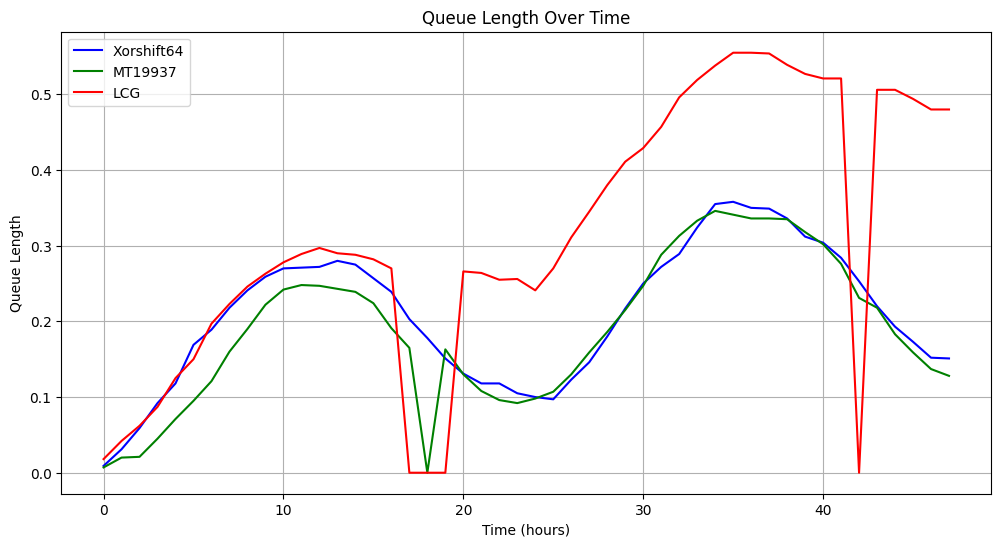

In [40]:
plt.figure(figsize=(12, 6))
time = np.arange(0, 48, 1)
for algo, data in simulation.items():
    plt.plot(time, data['events_queue'], label=algo, color=colors[algo])
plt.title('Queue Length Over Time')
plt.xlabel('Time (hours)')
plt.ylabel('Queue Length')
plt.legend()
plt.grid()
plt.show()

###### Graficamos el tiempo promedio en el sistema por cliente.

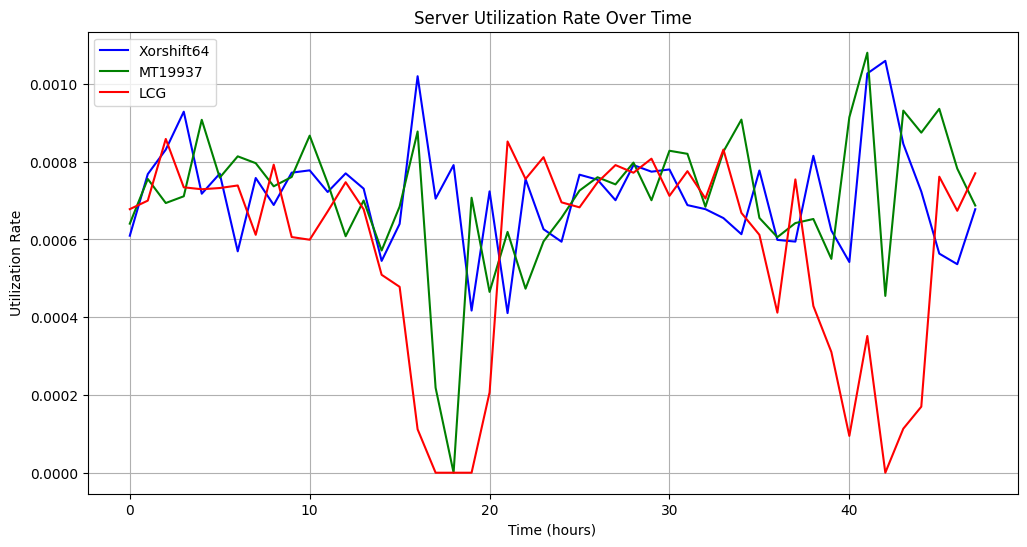

In [41]:
plt.figure(figsize=(12, 6))
for algo, data in simulation.items():
    plt.plot(time, data['sv_utilization_rate'], label=algo, color=colors[algo])
plt.title('Server Utilization Rate Over Time')
plt.xlabel('Time (hours)')
plt.ylabel('Utilization Rate')
plt.legend()
plt.grid()
plt.show()

###### Graficamos el porcentaje de tiempo que el servidor está ocupado.